# Latent Space Approaches to Social Network Analysis

In [16]:
pip install networkx

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


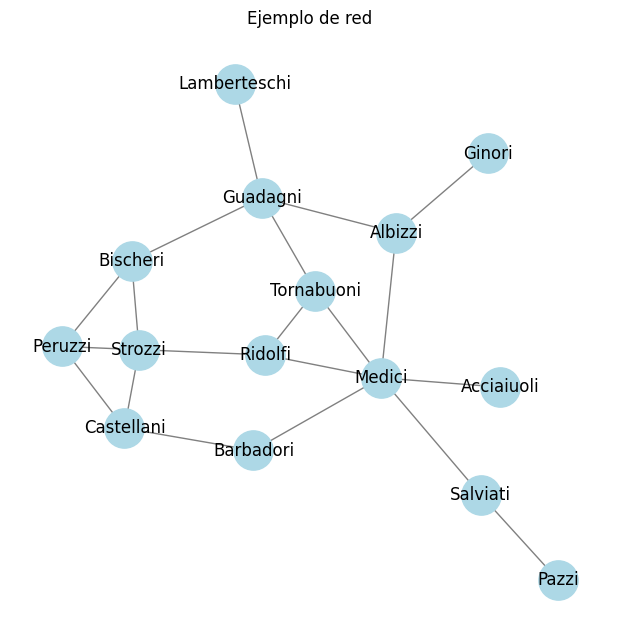

In [15]:
import networkx as nx
import matplotlib.pyplot as plt


G = nx.florentine_families_graph()

# Dibujar la red
plt.figure(figsize=(6,6))
nx.draw(G, with_labels=True, node_color='lightblue', edge_color='gray', node_size=800)
plt.title("Ejemplo de red")
plt.show()


In [26]:
G.nodes()

NodeView(('Acciaiuoli', 'Medici', 'Castellani', 'Peruzzi', 'Strozzi', 'Barbadori', 'Ridolfi', 'Tornabuoni', 'Albizzi', 'Salviati', 'Pazzi', 'Bischeri', 'Guadagni', 'Ginori', 'Lamberteschi'))

In [27]:
G.edges()

EdgeView([('Acciaiuoli', 'Medici'), ('Medici', 'Barbadori'), ('Medici', 'Ridolfi'), ('Medici', 'Tornabuoni'), ('Medici', 'Albizzi'), ('Medici', 'Salviati'), ('Castellani', 'Peruzzi'), ('Castellani', 'Strozzi'), ('Castellani', 'Barbadori'), ('Peruzzi', 'Strozzi'), ('Peruzzi', 'Bischeri'), ('Strozzi', 'Ridolfi'), ('Strozzi', 'Bischeri'), ('Ridolfi', 'Tornabuoni'), ('Tornabuoni', 'Guadagni'), ('Albizzi', 'Ginori'), ('Albizzi', 'Guadagni'), ('Salviati', 'Pazzi'), ('Bischeri', 'Guadagni'), ('Guadagni', 'Lamberteschi')])

In [24]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# 1. Dataset: Red de familias florentinas
G = nx.florentine_families_graph()
n = len(G.nodes)

# 2. Inicializar posiciones latentes aleatorias en R^2
Z = np.random.randn(n, 2)

# 3. Definir la función de energía potencial (U) y su gradiente (grad_U)
def U(Z):
    total = 0
    for i, j in G.edges():
        dist = np.linalg.norm(Z[i] - Z[j])
        total -= np.log(1 / (1 + np.exp(dist)))  # Probabilidad logística inversa
    return total

def grad_U(Z):
    grad = np.zeros_like(Z)
    for i, j in G.edges():
        dist = np.linalg.norm(Z[i] - Z[j])
        factor = np.exp(dist) / (1 + np.exp(dist))
        grad[i] += factor * (Z[i] - Z[j]) / (dist + 1e-6)
        grad[j] += factor * (Z[j] - Z[i]) / (dist + 1e-6)
    return grad


In [25]:

# 4. Implementar HMC
def hmc(Z_init, num_samples, epsilon=0.05, L=10, std_dev=1.0):
    samples = [Z_init]
    Z = Z_init.copy()
    
    for _ in range(num_samples):
        p = np.random.normal(0, std_dev, size=Z.shape)
        current_p = p.copy()
        
        p -= epsilon * grad_U(Z) / 2
        
        for _ in range(L):
            Z += epsilon * p
            p -= epsilon * grad_U(Z)
        
        p -= epsilon * grad_U(Z) / 2
        p = -p
        
        current_U = U(samples[-1])
        current_K = np.sum(current_p ** 2) / 2
        proposed_U = U(Z)
        proposed_K = np.sum(p ** 2) / 2
        
        if np.random.rand() < np.exp(current_U - proposed_U + current_K - proposed_K):
            samples.append(Z.copy())
        else:
            samples.append(samples[-1])
    
    return np.array(samples)

# 5. Ejecutar HMC
samples = hmc(Z, 100)

# 6. Graficar las posiciones finales de los nodos en el espacio latente
final_positions = samples[-1]
plt.scatter(final_positions[:, 0], final_positions[:, 1], c='blue')
for i, pos in enumerate(final_positions):
    plt.text(pos[0], pos[1], str(i), fontsize=12, ha='right')
plt.title("Posiciones Latentes de los Monjes")
plt.show()


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [19]:
samples

array([[[-1.95922513, -0.13362015],
        [-0.64610358, -0.51564811],
        [ 1.28757257,  0.95191846],
        ...,
        [-0.26051255,  1.6657873 ],
        [-0.42781316, -0.34729712],
        [ 0.07347252, -0.50025711]],

       [[-1.95922513, -0.13362015],
        [-0.64610358, -0.51564811],
        [ 1.28757257,  0.95191846],
        ...,
        [-0.26051255,  1.6657873 ],
        [-0.42781316, -0.34729712],
        [ 0.07347252, -0.50025711]],

       [[ 0.03017715,  0.34105989],
        [-0.10134412, -0.87318536],
        [ 0.72611131,  0.54304501],
        ...,
        [-1.08377328,  1.01172127],
        [-0.1635433 , -0.30137586],
        [ 0.46899783,  0.10443046]],

       ...,

       [[ 9.25659203,  0.83064596],
        [ 9.44193201,  0.82775688],
        [ 9.67332162,  0.90358725],
        ...,
        [ 8.46872214, -0.24738605],
        [ 9.090495  , -0.74423592],
        [ 8.54894865,  0.12676454]],

       [[ 9.58980796,  0.70161986],
        [ 9.04112401,  0.75

## References